# First exploration of Kaggle big five personality data

Ideas:

* Fill in the responses myself and compare my answers to the general
* Do summarize percentage values, accumulating the data together

In [26]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
rdf = pd.read_csv("../raw/data_final_rekeyed.tsv.gz", delimiter="\t", nrows=10000)
rdf.head()

,Unnamed: 0,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,...,dateload,screenw,screenh,introelapse,testelapse,endelapse,IPC,country,lat_appx_lots_of_err,long_appx_lots_of_err
0,0,4.0,5.0,5.0,4.0,5.0,5.0,5.0,4.0,4.0,...,2016-03-03 02:01:01,768.0,1024.0,9.0,234.0,6,1,GB,51.5448,0.1991
1,1,3.0,1.0,3.0,2.0,3.0,3.0,2.0,1.0,1.0,...,2016-03-03 02:01:20,1360.0,768.0,12.0,179.0,11,1,MY,3.1698,101.706
2,2,2.0,3.0,4.0,2.0,3.0,4.0,1.0,3.0,2.0,...,2016-03-03 02:01:56,1366.0,768.0,3.0,186.0,7,1,GB,54.9119,-1.3833
3,3,2.0,4.0,2.0,3.0,4.0,4.0,2.0,2.0,1.0,...,2016-03-03 02:02:02,1920.0,1200.0,186.0,219.0,7,1,GB,51.75,-1.25
4,4,3.0,3.0,3.0,3.0,5.0,3.0,3.0,1.0,3.0,...,2016-03-03 02:02:57,1366.0,768.0,8.0,315.0,17,2,KE,1.0,38.0


In [28]:
indices = list()

personality_cats = ["extraversion", "neuroticism", "agreeableness", "conscientiousness", "openness"]

category = list()
for i in range(0,50): 
    gothrough = i % 10
    set_of_questions = i // 10
    question_index = 1 + gothrough * 5 + set_of_questions
    indices.append(question_index)
    category.append(personality_cats[set_of_questions])
    # print(f"index {question_index} got {gothrough} set {set_of_questions}")
print(category)

['extraversion', 'extraversion', 'extraversion', 'extraversion', 'extraversion', 'extraversion', 'extraversion', 'extraversion', 'extraversion', 'extraversion', 'neuroticism', 'neuroticism', 'neuroticism', 'neuroticism', 'neuroticism', 'neuroticism', 'neuroticism', 'neuroticism', 'neuroticism', 'neuroticism', 'agreeableness', 'agreeableness', 'agreeableness', 'agreeableness', 'agreeableness', 'agreeableness', 'agreeableness', 'agreeableness', 'agreeableness', 'agreeableness', 'conscientiousness', 'conscientiousness', 'conscientiousness', 'conscientiousness', 'conscientiousness', 'conscientiousness', 'conscientiousness', 'conscientiousness', 'conscientiousness', 'conscientiousness', 'openness', 'openness', 'openness', 'openness', 'openness', 'openness', 'openness', 'openness', 'openness', 'openness']


In [29]:
question_names = list(rdf.columns)[1:51]
question_times = list(rdf.columns)[51:101]

design = pd.DataFrame({
    "question_name":question_names, 
    "question_time":question_times, 
    "category":category,
    "order":indices})
design

design.to_csv("../raw/design.tsv", sep="\t")

# Initial visuals

In [30]:
aggr_data = rdf[design.question_name].agg(['sum', 'count', 'mean', 'median']).T
aggr_data.reset_index(inplace=True)
aggr_data['category'] = design.category
aggr_data.head()

,index,sum,count,mean,median,category
0,EXT1,26705.0,10000.0,2.6705,3.0,extraversion
1,EXT2,32330.0,10000.0,3.2330,3.0,extraversion
2,EXT3,33408.0,10000.0,3.3408,3.0,extraversion
3,EXT4,28598.0,10000.0,2.8598,3.0,extraversion
4,EXT5,33038.0,10000.0,3.3038,3.0,extraversion


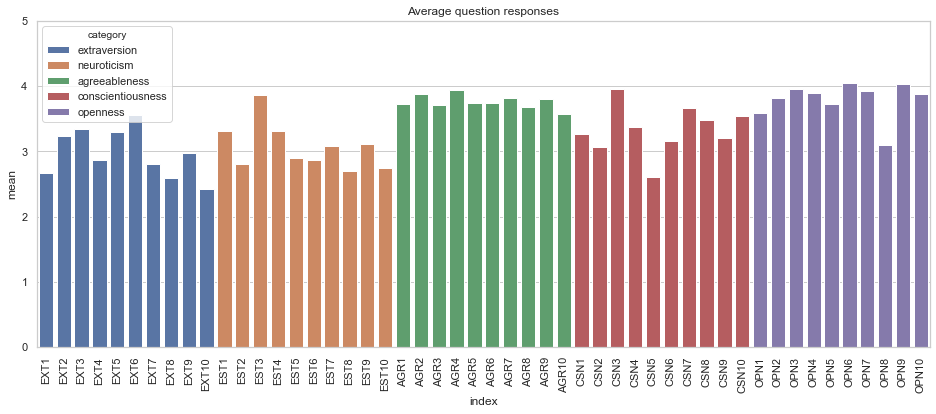

In [31]:
sns.set(style="whitegrid")

plt.figure(figsize=(16,6))
chart = sns.barplot(x="index", y="mean", hue="category", data=aggr_data, dodge=False)
_ = chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
#chart = chart
_ = chart.set_title("Average question responses")
_ = chart.axes.set_ylim(0, 5)


# Aggregating the data

Ideal outputs:

* Output mean score per category
* Also, output ranking for each category, and quartile of scoring

In [32]:
agg_answers = pd.DataFrame()
for category in design.category.unique():
    target_questions = design[design.category == category].question_name
    df = rdf[target_questions]
    means = df.agg(['mean'], axis=1)
    agg_answers[category] = means['mean'].to_list()

mean_colnames = [f'{col}_mean' for col in agg_answers.columns]
agg_answers.columns = mean_colnames
    
summarized_data = agg_answers
# df[design.question_name].agg(['sum', 'count', 'mean', 'median']).T

In [33]:
def calc_index(values):
    val_position = np.argsort(values.to_list()) + 1
    return val_position

def calc_percentiles(values):
    val_position = np.argsort(values.to_list())
    perc = val_position / max(val_position) * 100
    return perc

In [34]:
agg_indices = agg_answers.apply(calc_index, axis=0)
agg_percentiles = agg_answers.apply(calc_percentiles, axis=0)

agg_indices.columns = [f'{col}_rank' for col in agg_indices.columns]
agg_percentiles.columns = [f'{col}_perc' for col in agg_percentiles.columns]

combined_summarized_df = pd.concat([agg_answers, agg_indices, agg_percentiles], axis=1)

# Output summarized data

In [35]:
combined_summarized_df.shape

(10000, 15)

In [36]:
combined_summarized_df.to_csv("../raw/combined_summarized.tsv.gz", sep="\t", compression="gzip")

# Some visuals of summarized values

In [37]:
summarized_long = combined_summarized_df.melt(value_vars=mean_colnames)

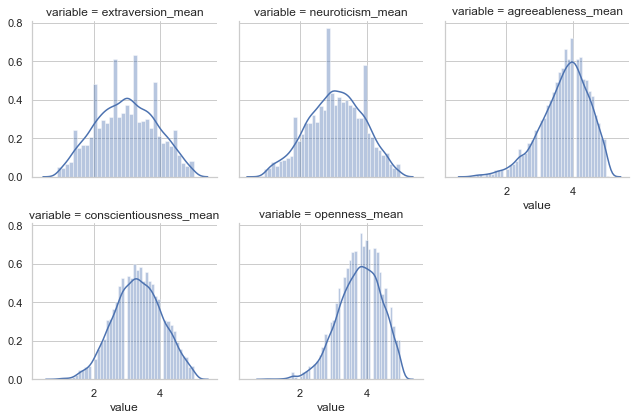

In [38]:
grid = sns.FacetGrid(summarized_long, col="variable", col_wrap=3)
grid.map(sns.distplot, "value")

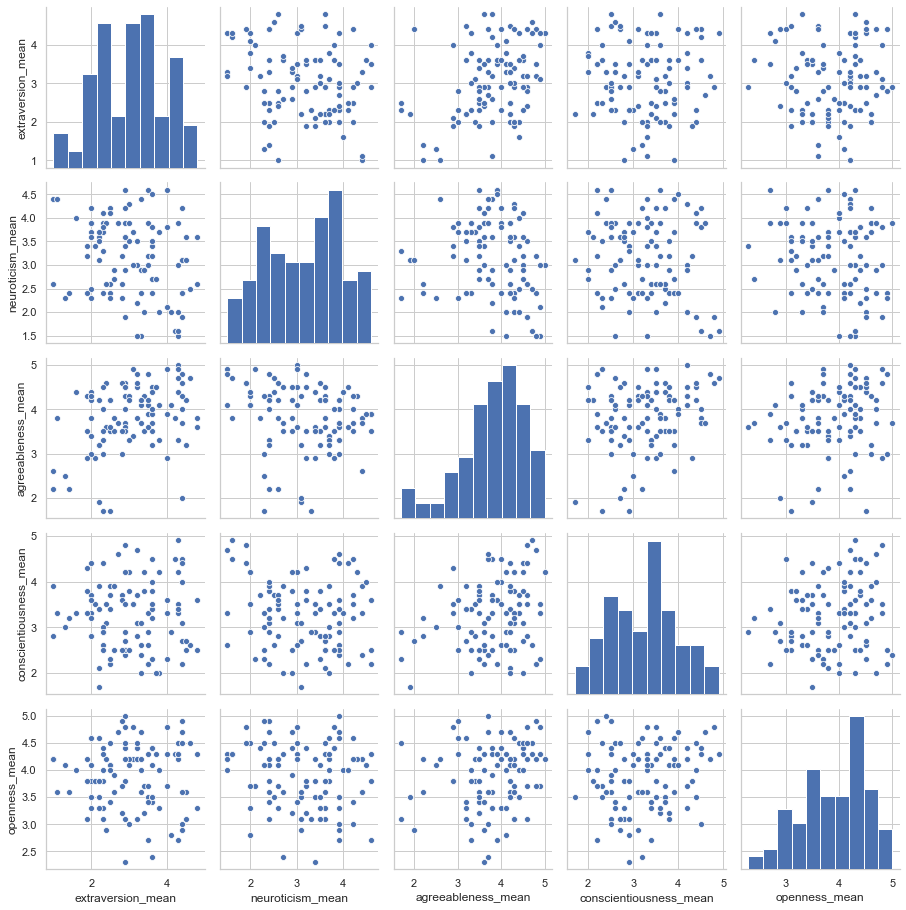

In [39]:
sns.pairplot(combined_summarized_df[mean_colnames].iloc[1:100, :])

In [ ]:
#sns.pairplot()

sns.set(style="white")

#df = sns.load_dataset("iris")

g = sns.PairGrid(combined_summarized_df[mean_colnames].iloc[1:10000, :], diag_sharey=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot, colors="C0")
g.map_diag(sns.kdeplot, lw=2)